In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Set up paths in your Drive
data_dir = "/content/drive/MyDrive/CSE366-FINALproject_dataset/Dataset"  # Adjust this path as needed
checkpoint_path = "/content/drive/MyDrive/modelCheckpoint/rice_model.keras"

In [7]:
# Import Libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [8]:
# Constants
IMAGE_SIZE = 70
BATCH_SIZE = 60
CHANNELS = 3
EPOCHS = 100

In [9]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 14761 files belonging to 3 classes.


In [10]:
# Show class names
class_names = dataset.class_names
print("Classes:", class_names)

Classes: ['Augmented Miniket Rice', 'Black Background', 'Original Miniket Rice']


Image batch shape: (60, 70, 70, 3)


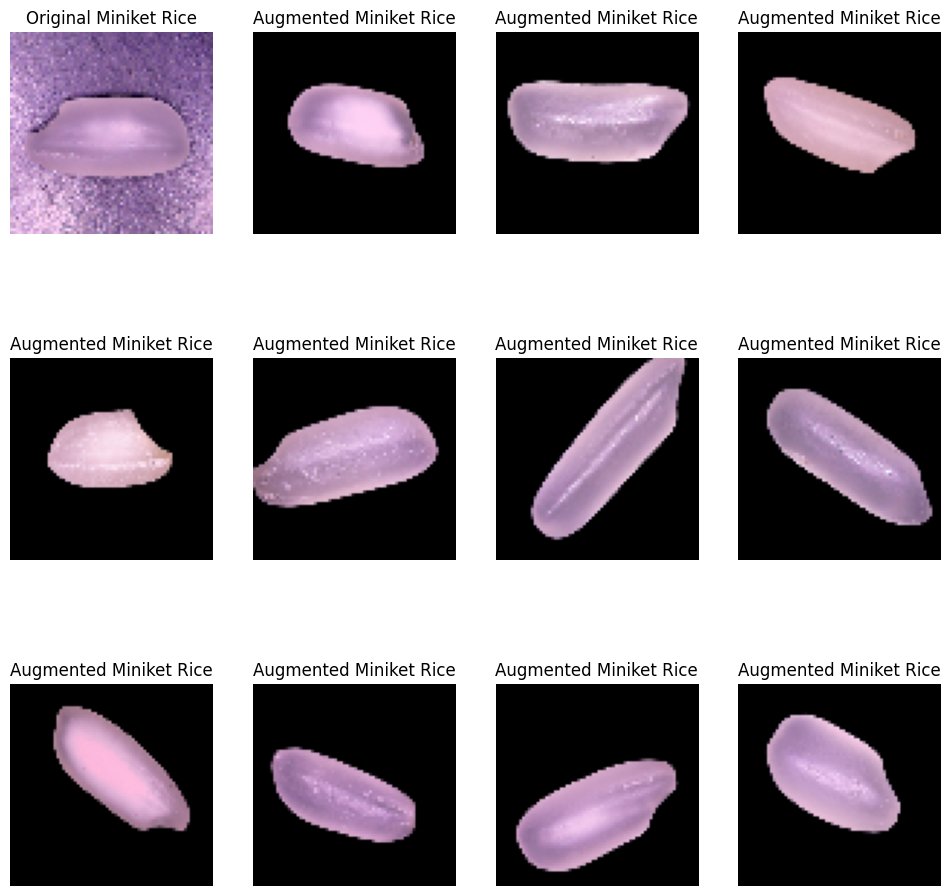

In [ ]:
# Show a batch of images
plt.figure(figsize=(12, 12))
for image_batch, label_batch in dataset.take(1):
    print("Image batch shape:", image_batch.shape)
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
plt.show()

In [ ]:
# Dataset partitioning
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds = ds.shuffle(shuffle_size, seed=12)
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [ ]:
# Optimize data pipeline
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
# Model architecture
n_classes = len(class_names)
model = models.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),

    layers.Conv2D(32, (2, 2), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # softmax already applied
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1
)

In [ ]:
# Model training
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

Epoch 1/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8048 - loss: 0.5047
Epoch 1: val_accuracy improved from -inf to 0.85373, saving model to /content/drive/MyDrive/modelCheckpoint/rice_model.keras
197/197 ━━━━━━━━━━━━━━━━━━━━ 179s 557ms/step - accuracy: 0.8050 - loss: 0.5043 - val_accuracy: 0.8537 - val_loss: 0.3531
Epoch 2/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8500 - loss: 0.3644
Epoch 2: val_accuracy did not improve from 0.85373
197/197 ━━━━━━━━━━━━━━━━━━━━ 72s 233ms/step - accuracy: 0.8500 - loss: 0.3644 - val_accuracy: 0.8537 - val_loss: 0.4012
Epoch 3/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8456 - loss: 0.3763
Epoch 3: val_accuracy improved from 0.85373 to 0.85518, saving model to /content/drive/MyDrive/modelCheckpoint/rice_model.keras
197/197 ━━━━━━━━━━━━━━━━━━━━ 81s 231ms/step - accuracy: 0.8456 - loss: 0.3763 - val_accuracy: 0.8552 - val_loss: 0.3308
Epoch 4/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0

In [ ]:
# Evaluation
scores = model.evaluate(test_ds)
print("Test Loss:", scores[0])
print("Test Accuracy:", scores[1])

26/26 ━━━━━━━━━━━━━━━━━━━━ 56s 55ms/step - accuracy: 0.9977 - loss: 0.0099
Test Loss: 0.022556329146027565
Test Accuracy: 0.9967948794364929


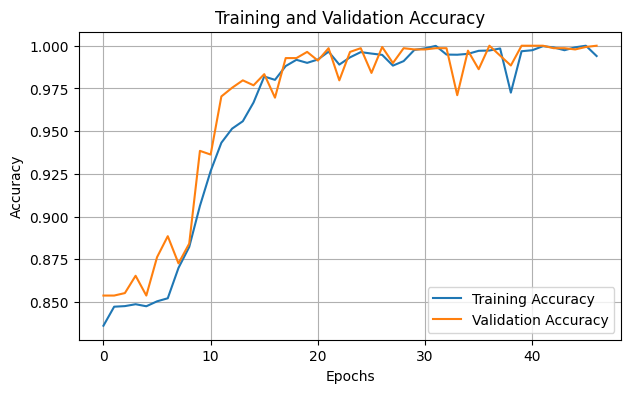

In [ ]:
# Accuracy plot
plt.figure(figsize=(7, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

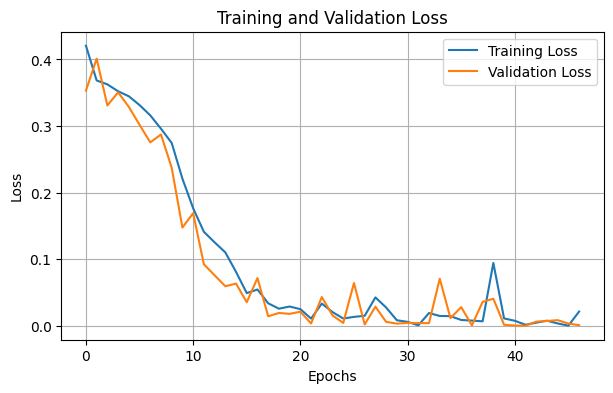

In [ ]:
# Loss plot
plt.figure(figsize=(7, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_model(input_shape=(70, 70, 3), num_classes=3):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

model = create_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 68, 68, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 34, 34, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,579 (3.42 MB)

 Trainable params: 896,579 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [2]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# Make sure these constants are defined in a preceding cell
# Constants
# IMAGE_SIZE = 70
# BATCH_SIZE = 60
# data_dir = "/content/drive/MyDrive/CSE366-FINALproject_dataset/Dataset" # Adjust this path as needed

# Load dataset
# This cell must be run before the cell that converts dataset to numpy arrays
import tensorflow as tf # Ensure tensorflow is imported
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 14761 files belonging to 3 classes.


In [12]:
# Calculate the number of batches for train/val/test split
train_size = int(0.7 * len(dataset))  # 70% training
val_size = int(0.2 * len(dataset))    # 20% validation
test_size = len(dataset) - train_size - val_size  # 10% testing

# Split the dataset
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size).take(test_size)

# Optimize dataset performance
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,  # Use the EPOCHS constant you defined earlier
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            checkpoint_path,  # Use your checkpoint path
            save_best_only=True,
            monitor='val_accuracy',
            mode='max'
        )
    ]
)

Epoch 1/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 3331s 19s/step - accuracy: 0.7812 - loss: 3.3776 - val_accuracy: 0.8391 - val_loss: 0.3763
Epoch 2/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8456 - loss: 0.3743 - val_accuracy: 0.8405 - val_loss: 0.3624
Epoch 3/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8463 - loss: 0.3553 - val_accuracy: 0.8405 - val_loss: 0.3816
Epoch 4/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8458 - loss: 0.3499 - val_accuracy: 0.8412 - val_loss: 0.3409
Epoch 5/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8495 - loss: 0.3317 - val_accuracy: 0.8476 - val_loss: 0.3267
Epoch 6/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8706 - loss: 0.2932 - val_accuracy: 0.9231 - val_loss: 0.2036
Epoch 7/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9290 - loss: 0.1764 - val_accuracy: 0.9776 - val_loss: 0.0598
Epoch 8/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9819 - loss: 0.0505 

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

###another model

In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

In [ ]:
# Constants
IMAGE_SIZE = 224  # DenseNet201 expects at least 224x224
BATCH_SIZE = 60
EPOCHS = 100

In [ ]:
# Load Dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/CSE366-FINALproject/Dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
n_classes = len(class_names)

Found 14761 files belonging to 3 classes.


In [ ]:
# Split dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle_size=10000):
    ds = ds.shuffle(shuffle_size, seed=12)
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
# Prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
# Base model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model.trainable = False  # Freeze base model

In [ ]:
# Full model
model = Sequential([
    layers.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = 'I:\\codes\\modelPath\\best_model.h5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

In [ ]:
# Train model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.7927 - loss: 0.5566
Epoch 1: val_accuracy improved from -inf to 0.83925, saving model to I:\codes\modelPath\best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - accuracy: 0.7929 - loss: 0.5560 - val_accuracy: 0.8392 - val_loss: 0.3737
Epoch 2/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.8422 - loss: 0.3823
Epoch 2: val_accuracy did not improve from 0.83925
197/197 ━━━━━━━━━━━━━━━━━━━━ 169s 858ms/step - accuracy: 0.8422 - loss: 0.3822 - val_accuracy: 0.8385 - val_loss: 0.3737
Epoch 3/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.8485 - loss: 0.3576
Epoch 3: val_accuracy did not improve from 0.83925
197/197 ━━━━━━━━━━━━━━━━━━━━ 167s 848ms/step - accuracy: 0.8484 - loss: 0.3576 - val_accuracy: 0.8385 - val_loss: 0.3449
Epoch 4/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.8459 - loss: 0.3551
Epoch 4: val_accuracy did not improve from 0.83925
197/197 ━━━━━━━━━━━━━━━━━━━━ 171s 866ms/step - accuracy: 0.8459 - loss: 0.3551 - val_accuracy: 0.8371 - val_loss: 0.3637
Epoch 5/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.8500 - loss: 0.3458
Epoch 5: v

197/197 ━━━━━━━━━━━━━━━━━━━━ 169s 857ms/step - accuracy: 0.8500 - loss: 0.3458 - val_accuracy: 0.8400 - val_loss: 0.3408
Epoch 6/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.8540 - loss: 0.3330
Epoch 6: val_accuracy improved from 0.83997 to 0.84142, saving model to I:\codes\modelPath\best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 168s 854ms/step - accuracy: 0.8540 - loss: 0.3331 - val_accuracy: 0.8414 - val_loss: 0.3276
Epoch 7/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.8465 - loss: 0.3455
Epoch 7: val_accuracy improved from 0.84142 to 0.84504, saving model to I:\codes\modelPath\best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 172s 872ms/step - accuracy: 0.8465 - loss: 0.3454 - val_accuracy: 0.8450 - val_loss: 0.3280
Epoch 8/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.8519 - loss: 0.3331
Epoch 8: val_accuracy did not improve from 0.84504
197/197 ━━━━━━━━━━━━━━━━━━━━ 167s 846ms/step - accuracy: 0.8518 - loss: 0.3331 - val_accuracy: 0.8429 - val_loss: 0.3246
Epoch 9/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.8498 - loss: 0.3482
Epoch 9: val_accuracy did not improve from 0.84504
197/197 ━━━━━━━━━━━━━━━━━━━━ 205s 861ms/step - accuracy: 0.8498 - loss: 0.3482 - val_accuracy: 0.8436 - val_loss: 0.3238
Epoch 10/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.8499 - loss: 0.3398
Epoch 10: val_accuracy improved from 0.84504 to 0.85083, saving model to I:\codes\modelPath\best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 168s 853ms/step - accuracy: 0.8499 - loss: 0.3398 - val_accuracy: 0.8508 - val_loss: 0.3157
Epoch 11/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.8555 - loss: 0.3288
Epoch 11: val_accuracy did not improve from 0.85083
197/197 ━━━━━━━━━━━━━━━━━━━━ 167s 846ms/step - accuracy: 0.8555 - loss: 0.3288 - val_accuracy: 0.8443 - val_loss: 0.3194
Epoch 12/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.8605 - loss: 0.3237
Epoch 12: val_accuracy did not improve from 0.85083
197/197 ━━━━━━━━━━━━━━━━━━━━ 202s 847ms/step - accuracy: 0.8605 - loss: 0.3237 - val_accuracy: 0.8494 - val_loss: 0.3419
Epoch 13/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.8595 - loss: 0.3185
Epoch 13: val_accuracy improved from 0.85083 to 0.85590, saving model to I:\codes\modelPath\best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 203s 852ms/step - accuracy: 0.8595 - loss: 0.3186 - val_accuracy: 0.8559 - val_loss: 0.3016
Epoch 14/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.8538 - loss: 0.3207
Epoch 14: val_accuracy did not improve from 0.85590
197/197 ━━━━━━━━━━━━━━━━━━━━ 167s 849ms/step - accuracy: 0.8538 - loss: 0.3207 - val_accuracy: 0.8537 - val_loss: 0.3062
Epoch 15/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.8615 - loss: 0.3133
Epoch 15: val_accuracy improved from 0.85590 to 0.85663, saving model to I:\codes\modelPath\best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 167s 850ms/step - accuracy: 0.8615 - loss: 0.3133 - val_accuracy: 0.8566 - val_loss: 0.3040
Epoch 16/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.8628 - loss: 0.3112
Epoch 16: val_accuracy improved from 0.85663 to 0.86749, saving model to I:\codes\modelPath\best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 202s 852ms/step - accuracy: 0.8628 - loss: 0.3113 - val_accuracy: 0.8675 - val_loss: 0.3044
Epoch 17/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.8579 - loss: 0.3177
Epoch 17: val_accuracy did not improve from 0.86749
197/197 ━━━━━━━━━━━━━━━━━━━━ 203s 857ms/step - accuracy: 0.8579 - loss: 0.3177 - val_accuracy: 0.8617 - val_loss: 0.2911
Epoch 18/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.8621 - loss: 0.3077
Epoch 18: val_accuracy improved from 0.86749 to 0.86966, saving model to I:\codes\modelPath\best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 167s 850ms/step - accuracy: 0.8621 - loss: 0.3077 - val_accuracy: 0.8697 - val_loss: 0.2939
Epoch 19/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - accuracy: 0.8599 - loss: 0.3105
Epoch 19: val_accuracy did not improve from 0.86966
197/197 ━━━━━━━━━━━━━━━━━━━━ 166s 842ms/step - accuracy: 0.8599 - loss: 0.3105 - val_accuracy: 0.8617 - val_loss: 0.2999
Epoch 20/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.8611 - loss: 0.3109
Epoch 20: val_accuracy did not improve from 0.86966
197/197 ━━━━━━━━━━━━━━━━━━━━ 170s 863ms/step - accuracy: 0.8611 - loss: 0.3109 - val_accuracy: 0.8660 - val_loss: 0.2981
Epoch 21/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.8613 - loss: 0.3039
Epoch 21: val_accuracy did not improve from 0.86966
197/197 ━━━━━━━━━━━━━━━━━━━━ 200s 850ms/step - accuracy: 0.8613 - loss: 0.3040 - val_accuracy: 0.8660 - val_loss: 0.2912
Epoch 22/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.8627 - loss: 0.3095


197/197 ━━━━━━━━━━━━━━━━━━━━ 170s 865ms/step - accuracy: 0.8708 - loss: 0.2992 - val_accuracy: 0.8769 - val_loss: 0.2828
Epoch 25/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.8726 - loss: 0.2976
Epoch 25: val_accuracy did not improve from 0.87690
197/197 ━━━━━━━━━━━━━━━━━━━━ 167s 847ms/step - accuracy: 0.8726 - loss: 0.2976 - val_accuracy: 0.8631 - val_loss: 0.2817
Epoch 26/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.8778 - loss: 0.2792
Epoch 26: val_accuracy did not improve from 0.87690
197/197 ━━━━━━━━━━━━━━━━━━━━ 167s 848ms/step - accuracy: 0.8777 - loss: 0.2792 - val_accuracy: 0.8755 - val_loss: 0.2874
Epoch 27/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.8669 - loss: 0.2980
Epoch 27: val_accuracy did not improve from 0.87690
197/197 ━━━━━━━━━━━━━━━━━━━━ 168s 854ms/step - accuracy: 0.8669 - loss: 0.2980 - val_accuracy: 0.8711 - val_loss: 0.2750
Epoch 28/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.8691 - loss: 0.2961


197/197 ━━━━━━━━━━━━━━━━━━━━ 167s 851ms/step - accuracy: 0.8732 - loss: 0.2858 - val_accuracy: 0.8805 - val_loss: 0.2756
Epoch 30/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - accuracy: 0.8673 - loss: 0.2942
Epoch 30: val_accuracy improved from 0.88052 to 0.88487, saving model to I:\codes\modelPath\best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 201s 847ms/step - accuracy: 0.8673 - loss: 0.2942 - val_accuracy: 0.8849 - val_loss: 0.2684
Epoch 31/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.8760 - loss: 0.2846
Epoch 31: val_accuracy did not improve from 0.88487
197/197 ━━━━━━━━━━━━━━━━━━━━ 169s 859ms/step - accuracy: 0.8760 - loss: 0.2846 - val_accuracy: 0.8827 - val_loss: 0.2680
Epoch 32/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.8750 - loss: 0.2835
Epoch 32: val_accuracy improved from 0.88487 to 0.88559, saving model to I:\codes\modelPath\best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 168s 851ms/step - accuracy: 0.8750 - loss: 0.2835 - val_accuracy: 0.8856 - val_loss: 0.2664
Epoch 33/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - accuracy: 0.8785 - loss: 0.2790
Epoch 33: val_accuracy did not improve from 0.88559
197/197 ━━━━━━━━━━━━━━━━━━━━ 166s 842ms/step - accuracy: 0.8785 - loss: 0.2790 - val_accuracy: 0.8718 - val_loss: 0.2774
Epoch 34/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.8770 - loss: 0.2752
Epoch 34: val_accuracy did not improve from 0.88559
197/197 ━━━━━━━━━━━━━━━━━━━━ 171s 867ms/step - accuracy: 0.8770 - loss: 0.2753 - val_accuracy: 0.8812 - val_loss: 0.2619
Epoch 35/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.8734 - loss: 0.2813
Epoch 35: val_accuracy did not improve from 0.88559
197/197 ━━━━━━━━━━━━━━━━━━━━ 169s 857ms/step - accuracy: 0.8734 - loss: 0.2813 - val_accuracy: 0.8856 - val_loss: 0.2548
Epoch 36/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.8778 - loss: 0.2752


197/197 ━━━━━━━━━━━━━━━━━━━━ 200s 848ms/step - accuracy: 0.8778 - loss: 0.2752 - val_accuracy: 0.8899 - val_loss: 0.2583
Epoch 37/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.8732 - loss: 0.2806
Epoch 37: val_accuracy did not improve from 0.88993
197/197 ━━━━━━━━━━━━━━━━━━━━ 166s 845ms/step - accuracy: 0.8732 - loss: 0.2806 - val_accuracy: 0.8755 - val_loss: 0.2595
Epoch 38/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.8775 - loss: 0.2797
Epoch 38: val_accuracy improved from 0.88993 to 0.89500, saving model to I:\codes\modelPath\best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 203s 850ms/step - accuracy: 0.8775 - loss: 0.2797 - val_accuracy: 0.8950 - val_loss: 0.2544
Epoch 39/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.8751 - loss: 0.2754
Epoch 39: val_accuracy did not improve from 0.89500
197/197 ━━━━━━━━━━━━━━━━━━━━ 166s 845ms/step - accuracy: 0.8752 - loss: 0.2754 - val_accuracy: 0.8747 - val_loss: 0.2550
Epoch 40/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.8822 - loss: 0.2639
Epoch 40: val_accuracy did not improve from 0.89500
197/197 ━━━━━━━━━━━━━━━━━━━━ 166s 842ms/step - accuracy: 0.8822 - loss: 0.2639 - val_accuracy: 0.8950 - val_loss: 0.2510
Epoch 41/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.8796 - loss: 0.2723
Epoch 41: val_accuracy did not improve from 0.89500
197/197 ━━━━━━━━━━━━━━━━━━━━ 167s 847ms/step - accuracy: 0.8796 - loss: 0.2723 - val_accuracy: 0.8950 - val_loss: 0.2497
Epoch 42/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.8797 - loss: 0.2680


197/197 ━━━━━━━━━━━━━━━━━━━━ 169s 858ms/step - accuracy: 0.8797 - loss: 0.2680 - val_accuracy: 0.8965 - val_loss: 0.2548
Epoch 43/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - accuracy: 0.8837 - loss: 0.2626
Epoch 43: val_accuracy improved from 0.89645 to 0.89935, saving model to I:\codes\modelPath\best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 167s 848ms/step - accuracy: 0.8837 - loss: 0.2626 - val_accuracy: 0.8993 - val_loss: 0.2496
Epoch 44/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.8881 - loss: 0.2584
Epoch 44: val_accuracy did not improve from 0.89935
197/197 ━━━━━━━━━━━━━━━━━━━━ 165s 840ms/step - accuracy: 0.8881 - loss: 0.2585 - val_accuracy: 0.8907 - val_loss: 0.2444
Epoch 45/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.8829 - loss: 0.2621
Epoch 45: val_accuracy improved from 0.89935 to 0.90587, saving model to I:\codes\modelPath\best_model.h5


197/197 ━━━━━━━━━━━━━━━━━━━━ 204s 849ms/step - accuracy: 0.8829 - loss: 0.2621 - val_accuracy: 0.9059 - val_loss: 0.2371
Epoch 46/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.8833 - loss: 0.2593
Epoch 46: val_accuracy did not improve from 0.90587
197/197 ━━━━━━━━━━━━━━━━━━━━ 170s 861ms/step - accuracy: 0.8833 - loss: 0.2593 - val_accuracy: 0.8936 - val_loss: 0.2434
Epoch 47/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.8869 - loss: 0.2593
Epoch 47: val_accuracy did not improve from 0.90587
197/197 ━━━━━━━━━━━━━━━━━━━━ 167s 847ms/step - accuracy: 0.8869 - loss: 0.2593 - val_accuracy: 0.9044 - val_loss: 0.2351
Epoch 48/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.8851 - loss: 0.2627
Epoch 48: val_accuracy did not improve from 0.90587
197/197 ━━━━━━━━━━━━━━━━━━━━ 201s 843ms/step - accuracy: 0.8851 - loss: 0.2627 - val_accuracy: 0.8972 - val_loss: 0.2375
Epoch 49/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.8891 - loss: 0.2547


In [ ]:
# Evaluate
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 80s 755ms/step - accuracy: 0.9137 - loss: 0.2262
Test Loss: 0.229236900806427
Test Accuracy: 0.9134615659713745


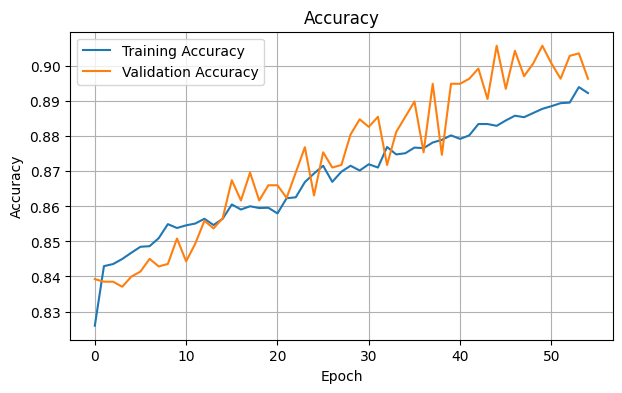

In [ ]:
# Plot Accuracy
plt.figure(figsize=(7, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

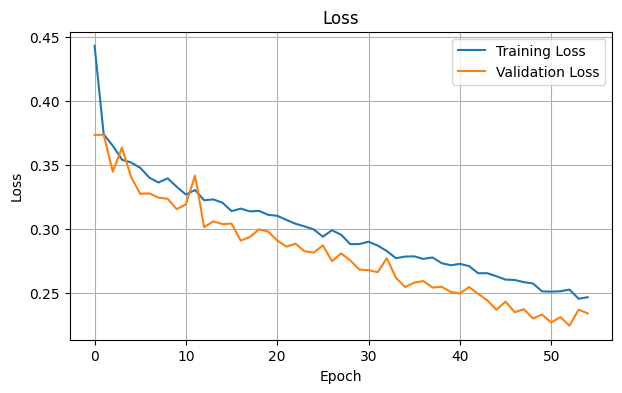

In [ ]:

# Plot Loss
plt.figure(figsize=(7, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, backend as K

class CustomPooling2D(layers.Layer):
    """
    A flexible 2‑D pooling layer.

    Parameters
    ----------
    pool_size : tuple(int, int) – default (2, 2)
        Size of the spatial window.
    strides   : tuple(int, int) or None – default None
        If None, strides == pool_size.
    padding   : {'valid', 'same'} – default 'valid'
    mode      : {'max', 'avg', 'mixed', 'gem'} – default 'max'
        - 'max'   → vanilla max‑pool
        - 'avg'   → vanilla average‑pool
        - 'mixed' → α·max + (1‑α)·avg
        - 'gem'   → Generalized‑Mean pooling with learnable p
    alpha     : float in [0, 1] – weight for 'mixed'
    p_init    : float – initial p for GeM
    """
    def __init__(self,
                 pool_size=(2, 2),
                 strides=None,
                 padding='valid',
                 mode='max',
                 alpha=0.5,
                 p_init=3.0,
                 **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
        self.strides   = strides or pool_size
        self.padding   = padding.upper()
        self.mode      = mode
        self.alpha     = alpha
        self.p_init    = p_init

        if self.mode == 'gem':
            # p is learnable (and constrained ≥ 1 to keep the math well‑behaved)
            self.p = tf.Variable(initial_value=p_init,
                                 trainable=True,
                                 dtype='float32',
                                 constraint=lambda x: tf.clip_by_value(x, 1.0, 10.0),
                                 name='gem_p')

    def call(self, inputs):
        if self.mode == 'max':
            return tf.nn.max_pool2d(inputs,
                                    ksize=self.pool_size,
                                    strides=self.strides,
                                    padding=self.padding)

        if self.mode == 'avg':
            return tf.nn.avg_pool2d(inputs,
                                    ksize=self.pool_size,
                                    strides=self.strides,
                                    padding=self.padding)

        if self.mode == 'mixed':
            max_pool = tf.nn.max_pool2d(inputs,
                                        ksize=self.pool_size,
                                        strides=self.strides,
                                        padding=self.padding)
            avg_pool = tf.nn.avg_pool2d(inputs,
                                        ksize=self.pool_size,
                                        strides=self.strides,
                                        padding=self.padding)
            return self.alpha * max_pool + (1.0 - self.alpha) * avg_pool

        if self.mode == 'gem':
            # Generalized‑Mean pooling: ( Σ x^p / N )^{1/p}
            # 1) raise to p
            x = tf.pow(inputs, self.p)
            # 2) average pool
            x = tf.nn.avg_pool2d(x,
                                 ksize=self.pool_size,
                                 strides=self.strides,
                                 padding=self.padding)
            # 3) (·)^{1/p}
            return tf.pow(x, 1.0 / self.p)

        raise ValueError(f"Unknown mode '{self.mode}'")

    def get_config(self):
        cfg = super().get_config()
        cfg.update(dict(pool_size=self.pool_size,
                        strides=self.strides,
                        padding=self.padding.lower(),
                        mode=self.mode,
                        alpha=self.alpha,
                        p_init=self.p_init))
        return cfg


### Efficient net

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
# Define n_classes
n_classes = len(class_names) # <--- Add this line

# Load EfficientNetB0 base model without top layer
base_model = EfficientNetB0(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), # Make sure IMAGE_SIZE is defined
                             include_top=False,
                             weights='imagenet')
base_model.trainable = False  # Freeze base model

# Build the full model
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)), # Make sure IMAGE_SIZE is defined
    base_model,
    layers.GlobalAveragePooling2D(),  # Custom pooling layer (ensure CustomPooling2D is defined or remove this comment if not custom)
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')  # Final classifier
])

# Compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 70, 70, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 3, 3, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,278 (16.70 MB)

 Trainable params: 328,707 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

###  Resnet 50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Load ResNet50 base model without top layer
base_model = ResNet50(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                      include_top=False,
                      weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Build the full model
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),  # Custom pooling layer
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')  # Final classifier
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 70, 70, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 3, 3, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

###custom

In [ ]:
# Mount Google Drive (if running in Colab and data is on Drive)
from google.colab import drive
drive.mount('/content/drive')

# Import Libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split # Although not used in this block, good to include if needed elsewhere
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping # For training later if desired

# Set up paths and Constants for this specific model run
data_dir = "/content/drive/MyDrive/CSE366-FINALproject_dataset/Dataset"  # Adjust this path as needed
IMAGE_SIZE = 70  # Set the image size appropriate for this model
BATCH_SIZE = 60  # Set the batch size
EPOCHS = 100 # Set the number of epochs for training later
checkpoint_path = "/content/drive/MyDrive/modelCheckpoint/custom_cnn_model.keras" # Set a checkpoint path

# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Show class names (optional, but good for verification)
class_names = dataset.class_names
print("Classes:", class_names)

# Dataset partitioning function
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds = ds.shuffle(shuffle_size, seed=12)
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

# Partition the dataset
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# Optimize data pipeline
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Get number of classes from the original class_names list
n_classes = len(class_names)

# Data Augmentation Layer (for small datasets)
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Build the Custom CNN Model
model = models.Sequential([
    layers.InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    data_augmentation,
    layers.Rescaling(1./255),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dropout(0.5),  # Helps with generalization

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')
])

# Compile
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # Using 'sparse_categorical_crossentropy' directly
    metrics=['accuracy']
)

model.summary()

# Callbacks (optional, for training)
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1
)

# Model training (optional, uncomment to train)
# history = model.fit(


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 14761 files belonging to 3 classes.
Classes: ['Augmented Miniket Rice', 'Black Background', 'Original Miniket Rice']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 70, 70, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ (None, 70, 70, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 70, 70, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 35, 35, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 35, 35, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,339 (4.36 MB)

 Trainable params: 1,142,339 (4.36 MB)

 Non-trainable params: 0 (0.00 B)